In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import style
style.use('ggplot')
from matplotlib.colors import ListedColormap
import seaborn as sns

import re
import os
import pickle
from glob import glob
from drone_troopers.models.flight_classifier import read_files, scale_n_process
from drone_troopers.preprocessing import preprocess, create_time_series_features
import shap

#clf models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GroupKFold, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [179]:
# Define normal ranges
normal_ranges = {
    'Motor Speed (RPM)': [(0, 8800)],
    'Engine Speed (RPM)': [(0, 8192)],
    'Intake Temperature (C)': [(-39, 46)],
    'Engine Coolant Temperature 1 (C)': [(-40, 91)],
    'Engine Coolant Temperature 2 (C)': [(-40, 91)],
    'Barometric Pressure (kpa)': [(70, 110)],
    'Fuel Trim': [(0, 1.33)],
    'Bus Voltage (V)': [(42, 50.4)],
    'Battery Current (A)': [(-30, 30), (-8, 7.3)],
    'Inverter Temperature (C)': [(0, 100)],
    # 'Target Fuel Pressure (bar)': [(1, 4.5)],
    'Fuel Pressure (bar)': [(0, 4.5)],
}

In [186]:
# Function to check if values are within the normal range
def check_normal(value, ranges):
    for min_val, max_val in ranges:
        if min_val <= value <= max_val:
            return 0
    return 1

def mark_above_alerts(series, n):
    alert_series = series.copy()
    for i in range(len(series)):
        if series.iloc[i] == 1:
            start_index = max(0, i - n)
            alert_series[start_index:i] = 1  # Mark n values above as 1
    return alert_series

In [187]:
def mark_state_ON(df, window_size=10, rolling_current_thresh=20, rolling_pow_thresh=30000) :
    df['State_ON'] = 0
    window_size = 10
    rolling_battery_current_sum = df['Battery Current (A)'].rolling(window=window_size).sum()
    rolling_power_generated_sum = df['Power Generated (W)'].rolling(window=window_size).sum()

    rc_exceeding_thresh = rolling_battery_current_sum > rolling_current_thresh
    pow_exceeding_thresh = rolling_power_generated_sum > rolling_pow_thresh

    index_exceeding = df.index[(rc_exceeding_thresh & pow_exceeding_thresh) == True]
    if len(index_exceeding) > 0:
        last_idx = df.index[-1]
        df.loc[index_exceeding[0]:, 'State_ON'] = 1
        df.loc[last_idx:, 'State_ON'] = 0
        
    return df

def mark_anomaly_rule_based(df, relief_time_step_window=5*4) :  
    df = mark_state_ON(df)
    
    df['alert'] = 0
    for column, ranges in normal_ranges.items():
        df['alert'] |= df[column].apply(lambda x: check_normal(x, ranges))
    df['alert'] &= df['State_ON']
    
    initial_temp_anomaly_window = 10
    intake_temp_anomaly_mask_1 = (df.loc[:initial_temp_anomaly_window, 'Intake Temperature (C)'] - df.loc[:initial_temp_anomaly_window, 'Engine Coolant Temperature 1 (C)']) > 5
    intake_temp_anomaly_mask_2 = (df.loc[:initial_temp_anomaly_window, 'Intake Temperature (C)'] - df.loc[:initial_temp_anomaly_window, 'Engine Coolant Temperature 2 (C)']) > 5
    df.loc[:initial_temp_anomaly_window, 'alert'] |= intake_temp_anomaly_mask_1.astype(np.int32)
    df.loc[:initial_temp_anomaly_window, 'alert'] |= intake_temp_anomaly_mask_2.astype(np.int32)
    
    
    df.alert = mark_above_alerts(df.alert, relief_time_step_window)
    return df.drop(columns='State_ON')

In [188]:
def get_file_paths(directory, extensions=['.csv', '.CSV', '.xlsx']):
    file_paths = []
    # Iterate over each extension
    for ext in extensions:
        # Use glob to find all files with the given extension in the directory and subdirectories
        file_paths.extend(glob(os.path.join(directory, '**', f'*{ext}'), recursive=True))
    return file_paths

In [189]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '1')

# Get the list of file paths
file_paths_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_normal)} normal log files.')

Found 166 normal log files.


In [190]:
# Specify the root directory
root_directory = os.path.join('logs', 'selected', '-1')

# Get the list of file paths
file_paths_non_normal = get_file_paths(root_directory)
print(f'Found {len(file_paths_non_normal)} non-normal log files.')

Found 97 non-normal log files.


In [202]:
concat_df = pd.DataFrame(dtype=np.float32)
i = 0

for idx, x in enumerate(file_paths_normal + file_paths_non_normal) :
    # if len(time_series_data) >= 200 :
    #     break
    if x.lower().endswith('.csv') :
        df = preprocess(pd.read_csv(x))
    else :
        df = preprocess(pd.read_excel(x))
    if df is not None and len(df) > 0:
        df['flightId'] = i
        i += 1
        
        df = create_time_series_features(df)
        df = df.reset_index(drop=True)
        
        concat_df = pd.concat((concat_df, df), axis=0, ignore_index=True)
concat_df.shape

(838492, 23)

In [203]:
concat_df = mark_anomaly_rule_based(concat_df)

In [204]:
concat_df.columns.tolist()

['Motor Speed (RPM)',
 'Engine Speed (RPM)',
 'Throttle (%)',
 'Intake Temperature (C)',
 'Engine Coolant Temperature 1 (C)',
 'Engine Coolant Temperature 2 (C)',
 'Barometric Pressure (kpa)',
 'Fuel Trim',
 'Fuel Consumption (g/min)',
 'Fuel Consumed (g)',
 'Bus Voltage (V)',
 'Battery Current (A)',
 'Power Generated (W)',
 'Inverter Temperature (C)',
 'Target Fuel Pressure (bar)',
 'Fuel Pressure (bar)',
 'Fuel Pump Speed (RPM)',
 'Cooling Pump Speed (RPM)',
 'flightId',
 'hour',
 'minute',
 'second',
 'microsecond',
 'alert']

In [205]:
feature_names = concat_df.columns[:-6].tolist()
feature_names

['Motor Speed (RPM)',
 'Engine Speed (RPM)',
 'Throttle (%)',
 'Intake Temperature (C)',
 'Engine Coolant Temperature 1 (C)',
 'Engine Coolant Temperature 2 (C)',
 'Barometric Pressure (kpa)',
 'Fuel Trim',
 'Fuel Consumption (g/min)',
 'Fuel Consumed (g)',
 'Bus Voltage (V)',
 'Battery Current (A)',
 'Power Generated (W)',
 'Inverter Temperature (C)',
 'Target Fuel Pressure (bar)',
 'Fuel Pressure (bar)',
 'Fuel Pump Speed (RPM)',
 'Cooling Pump Speed (RPM)']

In [206]:
concat_df.alert.value_counts()

alert
1    467485
0    371007
Name: count, dtype: int64

In [207]:
def add_lags(df, col_name, lags, fill_na=False):
    df = df.copy()
    for lag in lags :
        df[f'{col_name}_lag_{lag}'] = df[col_name].shift(lag) 
        if fill_na:
            df[f'{col_name}_lag_{lag}'] = df[f'{col_name}_lag_{lag}'].fillna(0)
    return df

In [208]:
for col in feature_names :
    concat_df = add_lags(concat_df, col, range(1, 10), fill_na=True)
concat_df.shape

(838492, 186)

In [209]:
concat_df[feature_names].quantile(0.99)

Motor Speed (RPM)                   8527.90
Engine Speed (RPM)                  8192.00
Throttle (%)                         100.00
Intake Temperature (C)                48.00
Engine Coolant Temperature 1 (C)      89.00
Engine Coolant Temperature 2 (C)      84.00
Barometric Pressure (kpa)            101.00
Fuel Trim                              1.32
Fuel Consumption (g/min)              46.80
Fuel Consumed (g)                   2649.00
Bus Voltage (V)                       50.82
Battery Current (A)                   14.41
Power Generated (W)                 4076.00
Inverter Temperature (C)              81.00
Target Fuel Pressure (bar)             4.50
Fuel Pressure (bar)                    3.60
Fuel Pump Speed (RPM)               3700.00
Cooling Pump Speed (RPM)            9042.00
Name: 0.99, dtype: float64

In [210]:
concat_df[feature_names].quantile(0.01)

Motor Speed (RPM)                   -0.4000
Engine Speed (RPM)                   0.0000
Throttle (%)                         5.0000
Intake Temperature (C)              11.0000
Engine Coolant Temperature 1 (C)    15.0000
Engine Coolant Temperature 2 (C)    15.0000
Barometric Pressure (kpa)           90.0000
Fuel Trim                            0.0000
Fuel Consumption (g/min)             0.0000
Fuel Consumed (g)                    0.0000
Bus Voltage (V)                     45.5600
Battery Current (A)                 -9.9809
Power Generated (W)                -52.0000
Inverter Temperature (C)            17.0000
Target Fuel Pressure (bar)           1.0000
Fuel Pressure (bar)                  0.0000
Fuel Pump Speed (RPM)                0.0000
Cooling Pump Speed (RPM)             0.0000
Name: 0.01, dtype: float64

In [211]:
grouped = concat_df.groupby('flightId')

# Extract unique flight IDs
flight_ids = grouped.groups.keys()

# Split flight IDs into train and test sets
train_flight_ids, test_flight_ids = train_test_split(list(flight_ids), test_size=0.2, random_state=42)

# Create boolean masks for training and testing sets
train_mask = concat_df['flightId'].isin(train_flight_ids)
test_mask = concat_df['flightId'].isin(test_flight_ids)

# Apply masks to split the data
X_train = concat_df[train_mask].drop(['flightId', 'alert'], axis=1) 
y_train = concat_df.loc[train_mask, 'alert']

X_test = concat_df[test_mask].drop(['flightId', 'alert'], axis=1)
y_test = concat_df.loc[test_mask, 'alert']

print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}')

X_train shape: (643915, 184)
X_test shape: (194577, 184)


In [212]:
y_train.value_counts()

alert
1    370198
0    273717
Name: count, dtype: int64

In [26]:
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [27]:
log_reg = LogisticRegression(max_iter=90000)
xgboost_clf = xgb.XGBClassifier(n_jobs=-1)
random_forest_clf = RandomForestClassifier(n_jobs=-1)
gradient_boost_clf = GradientBoostingClassifier(n_iter_no_change=100)
decision_tree_clf = DecisionTreeClassifier()

In [28]:
voting_clf = VotingClassifier(
    estimators=[
        ('decision_tree', decision_tree_clf),
        ('gradient_boost', gradient_boost_clf),
        ('log_reg', log_reg),
        ('random_forest', random_forest_clf),
        ('xgboost', xgboost_clf)
    ],
    voting='soft'
)

# Fit the VotingClassifier (note that it will refit the estimators)
voting_clf.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                             ('gradient_boost',
                              GradientBoostingClassifier(n_iter_no_change=100)),
                             ('log_reg', LogisticRegression(max_iter=90000)),
                             ('random_forest',
                              RandomForestClassifier(n_jobs=-1)),
                             ('xgboost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=No...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [45]:
# List of classifiers
classifiers = [
    "Decision Tree",
    "Gradient Boosting",
    "Logistic Regression",
    "Random Forest",
    "XGBoost",
]

classifiers = dict(zip(classifiers, voting_clf.estimators_))
classifiers['Voting Classifier'] = voting_clf
classifiers

{'Decision Tree': DecisionTreeClassifier(),
 'Gradient Boosting': GradientBoostingClassifier(n_iter_no_change=100),
 'Logistic Regression': LogisticRegression(max_iter=90000),
 'Random Forest': RandomForestClassifier(n_jobs=-1),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=-1,
               num_parallel_tree=None, random_state=None

In [46]:
# Dictionary to hold the results
results = {
    "Classifier": [],
    "Dataset": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    
    # Predict on training data
    y_train_pred = clf.predict(X_train_scaled)
    
    # Predict on test data
    y_test_pred = clf.predict(X_test_scaled)
    
    # Evaluate on training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision = precision_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    
    # Evaluate on test data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Print the results
    print(f"{clf_name} Classifier:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training Precision: {train_precision:.4f}")
    print(f"Training Recall: {train_recall:.4f}")
    print(f"Training F1 Score: {train_f1:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1:.4f}")
    print("\n" + "="*50 + "\n")
    
    # Append training results
    results["Classifier"].append(clf_name)
    results["Dataset"].append("Train")
    results["Accuracy"].append(train_accuracy)
    results["Precision"].append(train_precision)
    results["Recall"].append(train_recall)
    results["F1 Score"].append(train_f1)
    
    # Append test results
    results["Classifier"].append(clf_name)
    results["Dataset"].append("Test")
    results["Accuracy"].append(test_accuracy)
    results["Precision"].append(test_precision)
    results["Recall"].append(test_recall)
    results["F1 Score"].append(test_f1)


Decision Tree Classifier:
Training Accuracy: 0.9997
Training Precision: 1.0000
Training Recall: 0.9996
Training F1 Score: 0.9998
Test Accuracy: 0.9666
Test Precision: 0.9665
Test Recall: 0.9869
Test F1 Score: 0.9766


Gradient Boosting Classifier:
Training Accuracy: 0.9597
Training Precision: 0.9961
Training Recall: 0.9446
Training F1 Score: 0.9697
Test Accuracy: 0.9659
Test Precision: 0.9977
Test Recall: 0.9539
Test F1 Score: 0.9753


Logistic Regression Classifier:
Training Accuracy: 0.9203
Training Precision: 0.9844
Training Recall: 0.8972
Training F1 Score: 0.9388
Test Accuracy: 0.9424
Test Precision: 0.9777
Test Recall: 0.9398
Test F1 Score: 0.9584


Random Forest Classifier:
Training Accuracy: 0.9997
Training Precision: 0.9999
Training Recall: 0.9998
Training F1 Score: 0.9998
Test Accuracy: 0.9921
Test Precision: 0.9990
Test Recall: 0.9898
Test F1 Score: 0.9944


XGBoost Classifier:
Training Accuracy: 0.9899
Training Precision: 0.9973
Training Recall: 0.9879
Training F1 Score: 0.

In [47]:
# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)
results_df.set_index(['Classifier', 'Dataset']).sort_index()

Accuracy  Precision    Recall  F1 Score
Classifier          Dataset                                         
Decision Tree       Test     0.966577   0.966463  0.986853  0.976551
                    Train    0.999734   1.000000  0.999609  0.999805
Gradient Boosting   Test     0.965926   0.997708  0.953877  0.975301
                    Train    0.959728   0.996074  0.944594  0.969652
Logistic Regression Test     0.942397   0.977650  0.939808  0.958356
                    Train    0.920311   0.984424  0.897194  0.938787
Random Forest       Test     0.992104   0.999016  0.989779  0.994376
                    Train    0.999734   0.999853  0.999756  0.999805
Voting Classifier   Test     0.989427   0.999079  0.985917  0.992455
                    Train    0.996959   0.999708  0.995826  0.997763
XGBoost             Test     0.984669   0.995761  0.982443  0.989058
                    Train    0.989933   0.997257  0.987937  0.992575

In [48]:
with open(os.path.join("FinalModel",  "drone_troopers", "models", "voting_classifier_samples_model.pkl"), 'wb') as file:
    pickle.dump(voting_clf, file)

In [49]:
with open(os.path.join("FinalModel", "drone_troopers", "models", "std_scaler_samples_model.pkl"), "wb") as file:
    pickle.dump(std_scaler, file)

## What is SHAP?
SHAP is a method used to explain the output of machine learning models. It provides insight into which features (or columns) in your data are contributing to the model's predictions and how much they contribute. It does this by calculating "SHAP values" for each feature.

In [50]:
X_test = X_test.reset_index(drop=True)

In [72]:
# Create a SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(classifiers['XGBoost'])
shap_values = explainer.shap_values(X_test_scaled)

In [73]:
# %%time
# temp = explainer.shap_values(X_test.iloc[:1, :])
# shap.plots.force(explainer.expected_value, temp[0,:], X_test.iloc[:1, :], matplotlib = True)

### Explanation of SHAP Summary Plot

- **Key Components**:
   - **SHAP Values**: These values represent the contribution of each feature to the model's predictions. Positive SHAP values indicate that the feature increases the likelihood of a positive outcome (e.g., predicting `1`), while negative values indicate the opposite.
   - **Features**: Each feature in the dataset is represented on the vertical axis of the plot.

- **Interpreting the Plot**:
   - **Horizontal Axis**: Represents the SHAP values, indicating how much each feature pushes the prediction from the expected value. The values can be both positive and negative.
   - **Vertical Axis**: Lists all the features in the dataset. Features are ordered by the magnitude of their overall impact on the model's predictions.
   - **Dots**: Each dot represents a SHAP value for a single instance in the test set. The color of the dots indicates the feature value, with:
     - **Red Dots**: Higher feature values.
     - **Blue Dots**: Lower feature values.

- **Feature Importance**:
   - The features are sorted based on their importance, with the most impactful features at the top. This ordering helps quickly identify which features most influence the model's predictions.
   - The spread of the dots for each feature shows the range of influence across different instances. A wider spread indicates that the feature has a variable impact on the predictions.

- **Overall Insights**:
   - The summary plot helps visualize which features are the most important for the model, providing a quick reference for understanding model behavior.
   - It can highlight unexpected feature importance, allowing for deeper analysis into model decisions and guiding feature engineering efforts.

- **Conclusion**:
   - The SHAP summary plot is a powerful tool for interpreting model predictions, showing the impact of individual features on a global scale.
   - It enhances transparency, allowing stakeholders to understand which factors are driving predictions, and can aid in diagnosing model performance and improving interpretability.


In [74]:
X_test_scaled_df = pd.DataFrame(X_test, columns=X_test.columns)

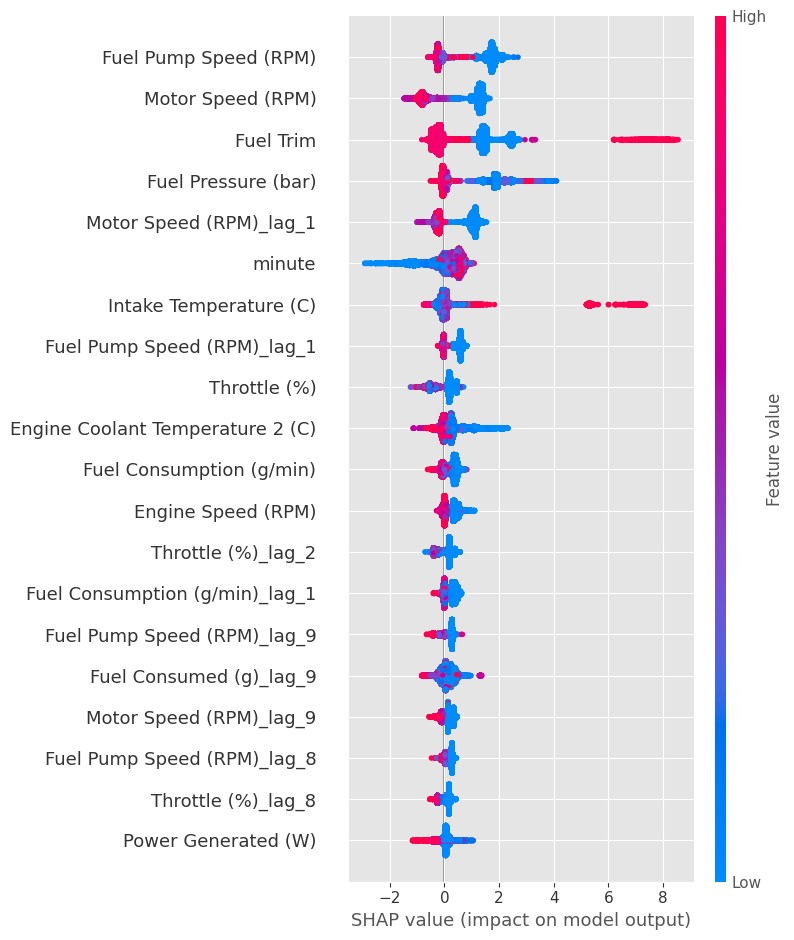

In [75]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_scaled_df, show=False, max_display=20)
plt.show()

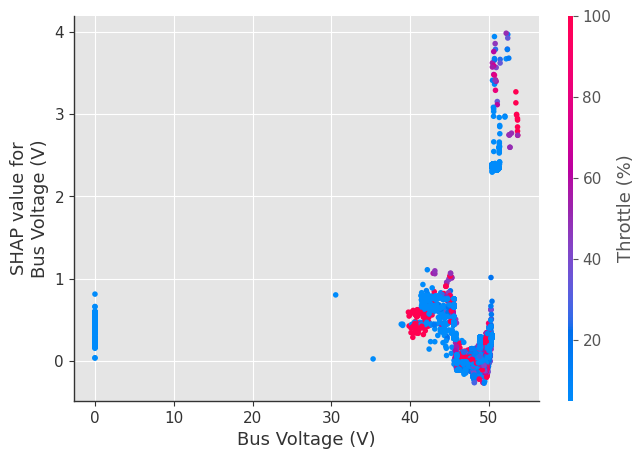

In [76]:
shap.dependence_plot("Bus Voltage (V)", shap_values, X_test_scaled_df, interaction_index="Throttle (%)")

In [77]:
y_test = y_test.reset_index(drop=True)

### Explaination of Force Plot
- **Predictions**: The force plot visualizes the contribution of each feature to a specific prediction made by the model. It shows how the features pull the prediction away from the expected value (the average prediction for the entire dataset).

- **Arrows**:

    - Each feature has an associated arrow pointing either to the right or left.
    - Right Arrows: Features that contribute positively to the prediction (increasing the likelihood of a certain class, e.g., predicting 1 for an anomaly).
    - Left Arrows: Features that contribute negatively to the prediction (decreasing the likelihood of that class).
    - The length of the arrow indicates the strength of that feature's influence on the prediction. Longer arrows represent a larger impact.
    
- **Expected Value**: The expected value (usually the mean prediction) is shown as a baseline in the force plot. It represents what the model would predict on average. Features that contribute positively push the prediction above this baseline, while negative contributions pull it below.

### Drone Data Interpretation
Suppose we have a model predicting whether a flight will experience an anomaly (1) or not (0). If you see the following in a force plot:
- An arrow for "Engine Temperature" pointing strongly to the right, this means that high engine temperature significantly increases the likelihood of predicting an anomaly.
- An arrow for "Engine Coolant Temperature" pointing slightly to the left suggests that lower coolant temperature speeds decrease the likelihood of an anomaly.

In [78]:
indices_y_test_0 = y_test[y_test == 0].index

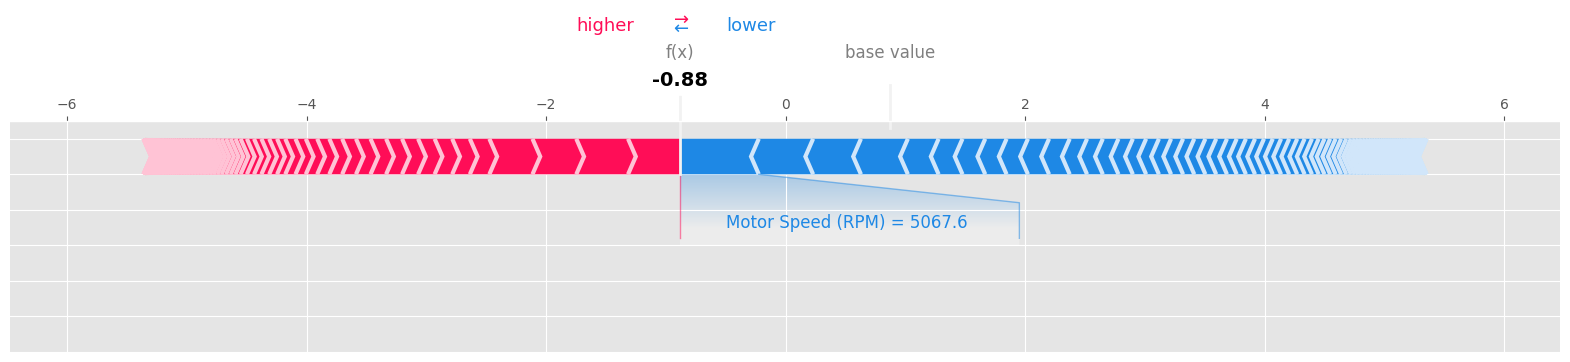

In [79]:
shap.plots.force(explainer.expected_value, shap_values[indices_y_test_0[0],:], X_test_scaled_df.iloc[indices_y_test_0[0], :], matplotlib = True)

In [80]:
indices_y_test_1 = y_test[y_test == 1].index

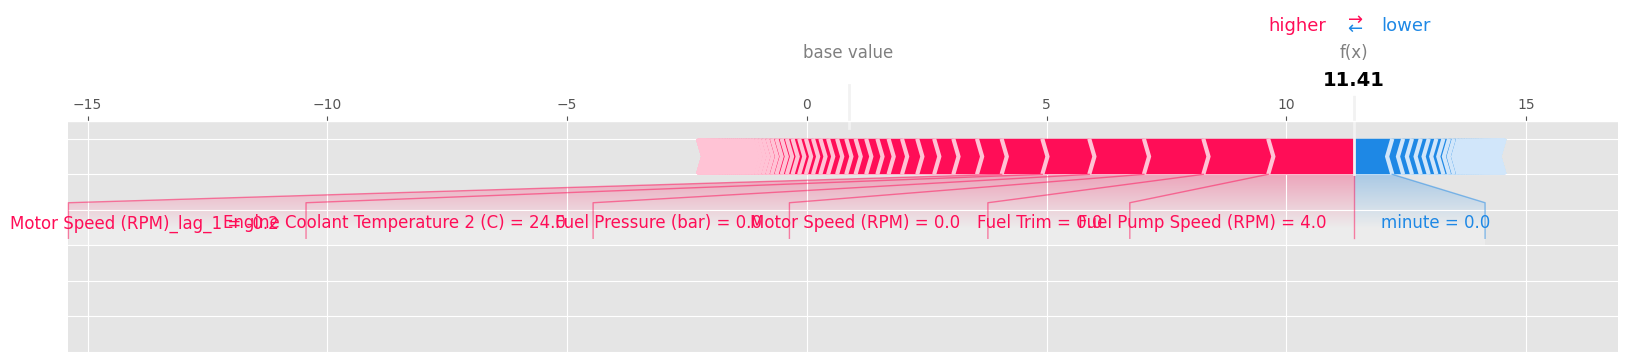

In [81]:
shap.plots.force(explainer.expected_value, shap_values[indices_y_test_1[0], :], X_test_scaled_df.iloc[indices_y_test_1[0], :],matplotlib = True)

### Explanation of SHAP Decision Plot for a Negative Prediction


- **Key Components**:
   - **Expected Value**: This is the baseline prediction, representing the average model output across the training data. It serves as a reference point.
   - **SHAP Values**: These values indicate the contribution of each feature to the prediction for each instance. Each feature's SHAP value shows how much it shifts the model's prediction from the expected value.
   - **Instances**: The plot visualizes the contributions of features for the first 100 instances in the test set where the true label is `0`.

- **Interpreting the Plot**:
   - **Horizontal Axis**: Represents the model's output, ranging from negative to positive predictions. In this context, negative values indicate the absence of an anomaly (prediction `0`).
   - **Features and Contributions**:
     - Each feature is represented by a line. The position of the line on the horizontal axis shows whether it contributes positively (toward predicting `1`) or negatively (toward predicting `0`).
     - The length of the lines indicates the magnitude of each feature's influence. Longer lines represent stronger effects on the prediction.
   - **Cumulative Effect**: The plot shows how features cumulatively influence the prediction. As you move from the expected value to the predicted output, the lines accumulate, illustrating how each feature pushes the prediction.

- **Overall Impact**:
   - The decision plot provides a comprehensive view of how different features work together to determine the prediction of `0` for each instance.
   - Features with lines pushing toward the left are reinforcing the prediction of no anomaly, while those pulling toward the right would suggest an anomaly (although in this case, we’re focusing on `0` predictions).

- **Conclusion**:
   - The decision plot helps visualize the rationale behind the model's negative predictions by showing the individual contributions of features.
   - It enhances interpretability, allowing users to see which features are most influential in leading to a prediction of `0`, thereby aiding in understanding the model's decision-making process.


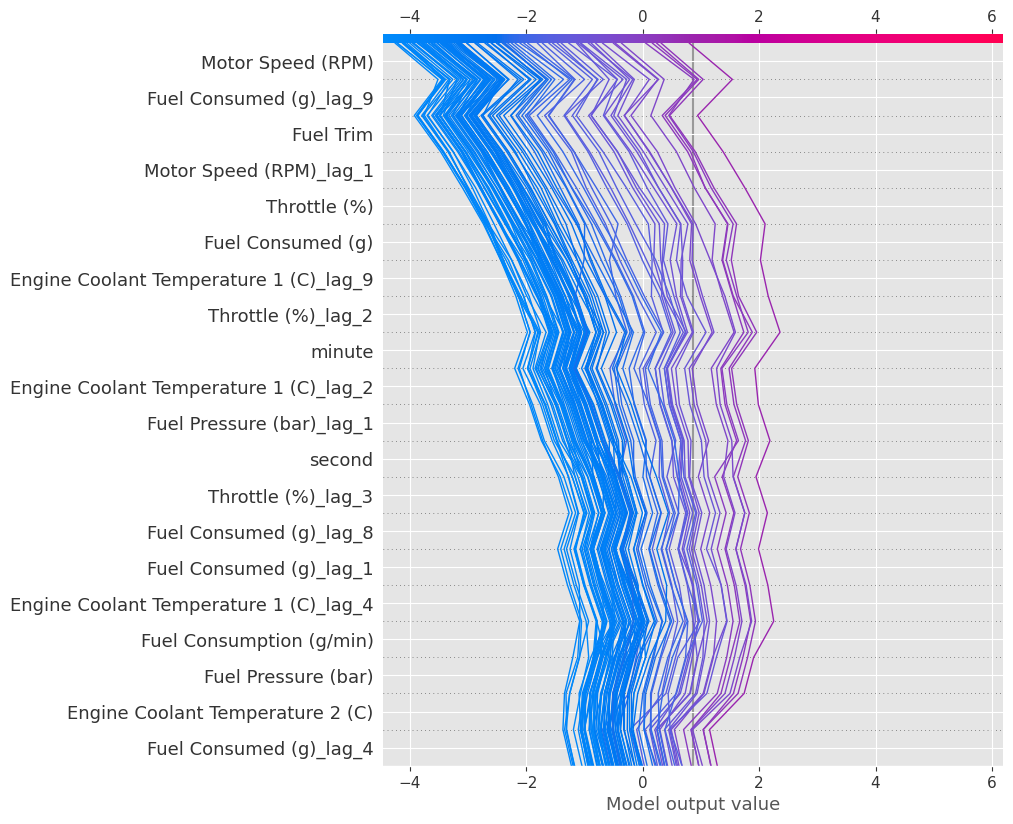

In [82]:
shap.decision_plot(explainer.expected_value, shap_values[indices_y_test_0[:100], :], X_test_scaled_df.columns)

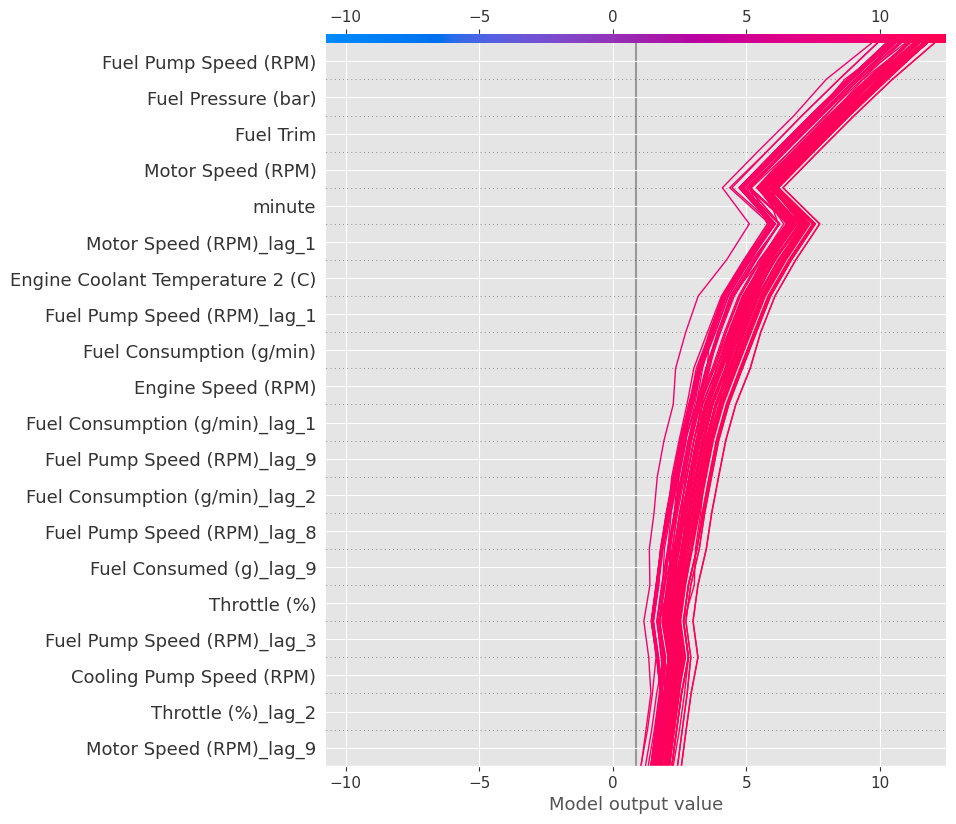

In [83]:
shap.decision_plot(explainer.expected_value, shap_values[indices_y_test_1[:100], :], X_test_scaled_df.columns)

In [220]:
import pandas as pd
import numpy as np

# Set a seed for reproducibility
np.random.seed(42)

# Generate random data
num_rows = 100
flight_ids = ['FL001', 'FL002', 'FL003', 'FL004', 'FL005']
data = {
    'flightId': np.random.choice(flight_ids, num_rows),
    'altitude': np.random.randint(30000, 40000, num_rows),
    'speed': np.random.randint(400, 600, num_rows),
    'temperature': np.random.uniform(-50, 0, num_rows),
    'timestamp': pd.date_range(start='2024-01-01', periods=num_rows, freq='T')
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
print("Sample DataFrame:")
display(df.shape)

# Group by 'flightId' and calculate mean of altitude and speed
grouped_df = df.groupby('flightId')

# Display the grouped DataFrame
print("\nGrouped DataFrame (Mean values):")
display(grouped_df)


Sample DataFrame:


(100, 5)


Grouped DataFrame (Mean values):


In [228]:
prediction_dfs = {flight_id: group.drop(columns='flightId') for flight_id, group in grouped_df}
[x['speed'].values for x in list(prediction_dfs.values())]

[array([547, 567, 527, 558, 489, 512, 539, 551, 552, 593, 560, 541, 420,
        447, 547, 594, 432, 421]),
 array([496, 563, 489, 598, 503, 511, 528, 447, 596, 559, 519, 551, 515,
        599, 563, 503, 483, 527, 481, 514, 518]),
 array([597, 523, 586, 469, 547, 438, 481, 584, 441, 406, 547, 535, 534,
        544, 527, 575]),
 array([515, 402, 546, 594, 495, 560, 528, 410, 577, 550, 459, 401, 408,
        498, 546, 447, 453, 560, 474, 565, 511, 498, 453, 562, 588, 527]),
 array([497, 538, 543, 492, 586, 546, 451, 498, 543, 436, 530, 512, 492,
        545, 509, 568, 467, 432, 586])]

In [216]:
for flight_id in grouped_df:
    print(flight_id)

flightId
altitude
speed
temperature
